## Возможность А/Б-тестирования для рекомендательной системы

### Цель проекта

Добавить в существующий сервис (2-й этап) возможность проведения А/Б-тестирования

### Задачи

1. Обучить вторую модель, используя для обработки текстов постов энкодер от трансформера при помощи библиотеки PyTorch. Данную модель принять за тестовую, модель из 2-го этапа — за контрольную;
2. Добавить разделение пользователей на 2 группы при помощи хэширования.
3. Добавить в сервис возможность применять одну из двух моделей для рекомендаций в зависимости от группы пользователя, логировать, какая модель применялась
4. В ответе endpoint-а указать группу, в которую попал пользователь ("control" или "test")

### Описание данных

Таблица `user_data`

Cодержит информацию о всех пользователях соц.сети

- `age`	- Возраст пользователя
- `city`	- Город пользователя
- `country` -	Страна пользователя
- `exp_group` -	Экспериментальная группа: некоторая зашифрованная категория
- `gender`	- Пол пользователя
- `id`	- Уникальный идентификатор пользователя
- `os`	- Операционная система устройства, с которого происходит пользование соц.сетью
- `source`	- Пришел ли пользователь в приложение с органического трафика или с рекламы

Таблица `post_text_df`

Содержит информацию о постах и уникальный ID каждой единицы с соответствующим ей текстом и топиком

- `id`	- Уникальный идентификатор поста
- `text` - Текстовое содержание поста
- `topic` - Основная тематика

Таблица `feed_data`

Содержит историю о просмотренных постах для каждого юзера

- `timestamp` - Время, когда был произведен просмотр
- `user_id` - id пользователя, который совершил просмотр
- `post_id`	- id просмотренного поста
- `action`	- Тип действия: просмотр или лайк
- `target`	- 1 у просмотров, если почти сразу после просмотра был совершен лайк, иначе 0. У действий like пропущенное значение

## Параметры и подключаемые библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from dotenv import load_dotenv
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sqlalchemy import create_engine

## Подключение к базе и основные таблицы
### users

In [3]:
# Создадим подключение к базе данных

load_dotenv()
conn_url = os.environ.get("POSTGRES_URL")

In [4]:
# Посмотрим на данные о пользователях

user_data = pd.read_sql(
    "SELECT * FROM public.user_data",
    conn_url
)
user_data

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [5]:
# Проверим на пропущенные значения

user_data.isna().any()

user_id      False
gender       False
age          False
country      False
city         False
exp_group    False
os           False
source       False
dtype: bool

In [6]:
# Запросим количество просмотров по топикам для каждого юзера

user_view_by_topic = pd.read_sql(
    """
    SELECT public.feed_data.user_id, public.post_text_df.topic, COUNT(public.feed_data.action)
    FROM public.feed_data
    JOIN public.post_text_df ON public.feed_data.post_id=public.post_text_df.post_id
    WHERE public.feed_data.action='view'
    GROUP BY public.feed_data.user_id, public.post_text_df.topic;
    """,
    conn_url
)
user_view_by_topic.head()

,user_id,topic,count
0,200,business,28
1,200,covid,93
2,200,entertainment,14
3,200,movie,88
4,200,politics,58


In [7]:
# Развернем таблицу колонками по топикам

user_view_by_topic = user_view_by_topic.pivot_table(index="user_id",
                                                    columns="topic",
                                                    values="count")
user_view_by_topic.head(3)

topic,business,covid,entertainment,movie,politics,sport,tech
user_id,,,,,,,
200,28.0,93.0,14.0,88.0,58.0,64.0,13.0
201,29.0,172.0,33.0,269.0,72.0,86.0,29.0
202,19.0,158.0,27.0,276.0,59.0,77.0,21.0


In [8]:
# Уберем topic и user_id из названия колонок

user_view_by_topic.columns.name = None
user_view_by_topic.reset_index(inplace=True)
user_view_by_topic.head(3)

,user_id,business,covid,entertainment,movie,politics,sport,tech
0,200,28.0,93.0,14.0,88.0,58.0,64.0,13.0
1,201,29.0,172.0,33.0,269.0,72.0,86.0,29.0
2,202,19.0,158.0,27.0,276.0,59.0,77.0,21.0


In [9]:
# Заполним пустые значения нулями и проверим на пустые значения

user_view_by_topic.fillna(0, inplace=True)
user_view_by_topic.isna().sum()

user_id          0
business         0
covid            0
entertainment    0
movie            0
politics         0
sport            0
tech             0
dtype: int64

In [10]:
# Добавим ко всем пользователям колонки с просмотрами по топикам

user_data = pd.merge(user_data, user_view_by_topic, on="user_id", how="left")
user_data.head(3)

,user_id,gender,age,country,city,exp_group,os,source,business,covid,entertainment,movie,politics,sport,tech
0,200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,14.0,88.0,58.0,64.0,13.0
1,201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,33.0,269.0,72.0,86.0,29.0
2,202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,27.0,276.0,59.0,77.0,21.0


In [11]:
# Сгенерируем доп фичи через кластеризацию юзеров

user_df = user_data.copy()
user_df.head()

,user_id,gender,age,country,city,exp_group,os,source,business,covid,entertainment,movie,politics,sport,tech
0,200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,14.0,88.0,58.0,64.0,13.0
1,201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,33.0,269.0,72.0,86.0,29.0
2,202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,27.0,276.0,59.0,77.0,21.0
3,203,0,18,Russia,Moscow,1,iOS,ads,19.0,71.0,11.0,137.0,25.0,49.0,9.0
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,8.0,31.0,5.0,64.0,10.0,17.0,3.0


In [12]:
# Преобразуем exp_forup в категориальный признак и установим индекс на user_id

user_df.exp_group = user_df.exp_group.astype("object")
user_df.set_index("user_id", inplace=True)
user_df.head(3)

,gender,age,country,city,exp_group,os,source,business,covid,entertainment,movie,politics,sport,tech
user_id,,,,,,,,,,,,,,
200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,14.0,88.0,58.0,64.0,13.0
201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,33.0,269.0,72.0,86.0,29.0
202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,27.0,276.0,59.0,77.0,21.0


In [13]:
# Применим трансформер для преобразования фичей

user_obj_cols = list(user_df.select_dtypes(include='object').columns)
user_num_cols = list(user_df.select_dtypes(exclude='object').columns)

# Сохраним индексы этих колонок

user_obj_cols_idx = [list(user_df.columns).index(col) for col in user_obj_cols]
user_num_cols_idx = [list(user_df.columns).index(col) for col in user_num_cols]

t_users = [
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), user_obj_cols_idx),
    ('std', StandardScaler(), user_num_cols_idx)
]

In [14]:
#%%script false --no-raise-error

# Подберем оптимальное числло кластеров

distortion = []
K = range(1, 20) 

for k in K:
    user_pipe = Pipeline([("transform", ColumnTransformer(t_users)),
                          
                          ("kmeans", KMeans(n_clusters=k, random_state=0))])
    
    user_pipe.fit(user_df)
    distortion.append(user_pipe[1].inertia_)

In [15]:
%%script false --no-raise-error

fig = plt.figure()
fig.set_size_inches(16, 10)
plt.plot(K, distortion, "s-")
plt.xticks
plt.show()

Couldn't find program: 'false'


In [16]:
# Разделим юзеров по 8 кластерам и вычислим межкластерное расстояние, которое используем как фичи

user_pipe = Pipeline([("transform", ColumnTransformer(t_users)),

                      ("kmeans", KMeans(n_clusters=8, random_state=0))])

user_pipe.fit(user_df)

user_kmeans = user_pipe.transform(user_df)

# В качестве дополнительных признаков будем использовать расстояния до центров кластеров

user_kmeans_cols = [
    f"user_dist_to_{i + 1}_cluster" for i in range(user_kmeans.shape[1])]

user_kmeans = pd.DataFrame(user_kmeans, columns=user_kmeans_cols)
user_kmeans['user_num_cluster'] = user_pipe[1].labels_

user_kmeans.head(3)

,user_dist_to_1_cluster,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster
0,3.017298,3.578527,2.979593,2.221977,3.635041,3.928811,3.857473,4.662269,3
1,3.889771,6.056264,6.410042,4.467372,2.955178,3.267942,2.681371,3.399628,6
2,3.697253,5.540520,5.193849,3.193716,4.013128,4.113622,1.987895,3.736802,6


In [17]:
# Присоединим кластеры

user_data = pd.concat((user_data, user_kmeans), axis=1)

# переведем exp_group в категориальный признак
user_df.exp_group = user_df.exp_group.astype("object")

In [18]:
# Итоговая таблица по юзерам
user_data.head(3)

,user_id,gender,age,country,city,exp_group,os,source,business,covid,...,tech,user_dist_to_1_cluster,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster
0,200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,...,13.0,3.017298,3.578527,2.979593,2.221977,3.635041,3.928811,3.857473,4.662269,3
1,201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,...,29.0,3.889771,6.056264,6.410042,4.467372,2.955178,3.267942,2.681371,3.399628,6
2,202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,...,21.0,3.697253,5.540520,5.193849,3.193716,4.013128,4.113622,1.987895,3.736802,6


In [19]:
user_data.isna().any().sum()

0

### posts

In [20]:
# Данные о постах

post_text_df = pd.read_sql(
    "SELECT * FROM public.post_text_df",
    conn_url
)
post_text_df

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [21]:
# Трансформируем текст при помощи tfidf с предварительной обработкой

nltk.download("wordnet")

wnl = WordNetLemmatizer()


def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


vectorizer = TfidfVectorizer(
    stop_words="english",
    preprocessor=preprocessing
)
vect = vectorizer.fit_transform(post_text_df["text"]).toarray()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
# Развернем таблицу со словарем

vect_vocab = pd.DataFrame(
    vect,
    index=post_text_df.post_id,
    columns=vectorizer.get_feature_names_out()
)
vect_vocab.head(3)

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Генерим фичи на основе TfIdf

post_text_df['tfidf_sum'] = vect_vocab.sum(axis=1).reset_index()[0]
post_text_df['tfidf_mean'] = vect_vocab.mean(axis=1).reset_index()[0]
post_text_df['tfidf_max'] = vect_vocab.max(axis=1).reset_index()[0]

post_text_df.head(3)

,post_id,text,topic,tfidf_sum,tfidf_mean,tfidf_max
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.000190,0.495805
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.000258,0.308003
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.000276,0.261799


In [24]:
# Разделим на 16 кластеров тем самым сократим количество фичей

kmeans_posts = KMeans(n_clusters=16, random_state=0).fit(vect_vocab)

post_kmeans = kmeans_posts.transform(vect_vocab)

post_kmeans_cols = [
    f"post_dist_to_{i + 1}_cluster" for i in range(post_kmeans.shape[1])]

post_kmeans = pd.DataFrame(post_kmeans, columns=post_kmeans_cols)
post_kmeans['post_num_cluster'] = kmeans_posts.labels_
post_kmeans.head(3)

,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,post_dist_to_5_cluster,post_dist_to_6_cluster,post_dist_to_7_cluster,post_dist_to_8_cluster,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster
0,1.041581,1.017668,1.019208,1.000911,1.031834,1.009951,1.041794,1.036095,1.019183,1.006183,0.983297,1.004058,1.009302,0.919366,1.011768,1.030109,13
1,1.037858,1.013259,1.015774,0.996825,1.028048,1.010530,0.992664,1.033190,1.014563,1.003411,0.967705,0.999901,1.007325,0.989098,1.011587,1.028142,10
2,1.040713,1.011287,1.024541,0.997860,1.027201,1.010509,1.054104,1.035145,1.015846,1.005088,0.978229,1.006527,1.006882,0.950109,1.019272,1.027924,13


In [25]:
# Присоединим межкластерные расстояния к постам

post_text_df = pd.concat((post_text_df, post_kmeans), axis=1)

post_text_df.head(5)

,post_id,text,topic,tfidf_sum,tfidf_mean,tfidf_max,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,...,post_dist_to_8_cluster,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.000190,0.495805,1.041581,1.017668,1.019208,1.000911,...,1.036095,1.019183,1.006183,0.983297,1.004058,1.009302,0.919366,1.011768,1.030109,13
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.000258,0.308003,1.037858,1.013259,1.015774,0.996825,...,1.033190,1.014563,1.003411,0.967705,0.999901,1.007325,0.989098,1.011587,1.028142,10
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.000276,0.261799,1.040713,1.011287,1.024541,0.997860,...,1.035145,1.015846,1.005088,0.978229,1.006527,1.006882,0.950109,1.019272,1.027924,13
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.000144,0.537713,1.041159,1.017468,1.029216,1.002180,...,1.035985,1.020306,1.006496,0.977505,1.010382,1.009777,0.992911,1.022562,1.023690,10
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.000138,0.420251,1.044158,1.021138,1.031516,1.003333,...,1.038888,1.023036,1.008690,0.991778,1.020382,1.011292,1.025277,1.028433,1.033378,10


In [26]:
# Добавим количество лайков по постам

post_view_count = pd.read_sql(
    """
    SELECT public.feed_data.post_id, COUNT(public.feed_data.action) AS view_sum 
    FROM public.feed_data
    WHERE public.feed_data.action='view'
    GROUP BY public.feed_data.post_id;
    """,
    conn_url
)

post_text_df = pd.merge(post_text_df, post_view_count,
                        on="post_id", how="left")
post_text_df.head(3)

,post_id,text,topic,tfidf_sum,tfidf_mean,tfidf_max,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,...,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster,view_sum
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.000190,0.495805,1.041581,1.017668,1.019208,1.000911,...,1.019183,1.006183,0.983297,1.004058,1.009302,0.919366,1.011768,1.030109,13,8508.0
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.000258,0.308003,1.037858,1.013259,1.015774,0.996825,...,1.014563,1.003411,0.967705,0.999901,1.007325,0.989098,1.011587,1.028142,10,7495.0
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.000276,0.261799,1.040713,1.011287,1.024541,0.997860,...,1.015846,1.005088,0.978229,1.006527,1.006882,0.950109,1.019272,1.027924,13,8412.0


In [27]:
# Проверим на отсутсвующие значения

post_text_df.view_sum.isna().sum()

192

In [28]:
# Заполним отсутсвующие значения

post_text_df.fillna(0, inplace=True)
post_text_df.head(3)

,post_id,text,topic,tfidf_sum,tfidf_mean,tfidf_max,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,...,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster,view_sum
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.000190,0.495805,1.041581,1.017668,1.019208,1.000911,...,1.019183,1.006183,0.983297,1.004058,1.009302,0.919366,1.011768,1.030109,13,8508.0
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.000258,0.308003,1.037858,1.013259,1.015774,0.996825,...,1.014563,1.003411,0.967705,0.999901,1.007325,0.989098,1.011587,1.028142,10,7495.0
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.000276,0.261799,1.040713,1.011287,1.024541,0.997860,...,1.015846,1.005088,0.978229,1.006527,1.006882,0.950109,1.019272,1.027924,13,8412.0


In [29]:
post_text_df.isna().sum().any()

False

In [30]:
### Почистим переменные
%who

CatBoostClassifier	 ColumnTransformer	 K	 KMeans	 OneHotEncoder	 Pipeline	 StandardScaler	 TargetEncoder	 TfidfVectorizer	 
WordNetLemmatizer	 classification_report	 conn_url	 create_engine	 cross_validate	 distortion	 k	 kmeans_posts	 load_dotenv	 
nltk	 np	 os	 pd	 plt	 post_kmeans	 post_kmeans_cols	 post_text_df	 post_view_count	 
preprocessing	 re	 sns	 string	 t_users	 user_data	 user_df	 user_kmeans	 user_kmeans_cols	 
user_num_cols	 user_num_cols_idx	 user_obj_cols	 user_obj_cols_idx	 user_pipe	 user_view_by_topic	 vect	 vect_vocab	 vectorizer	 
warnings	 wnl	 


In [31]:
import gc
del user_view_by_topic
del user_df
del user_kmeans

del wnl
del preprocessing
del vectorizer
del vect
del vect_vocab
del kmeans_posts
del post_kmeans
del post_view_count

del KMeans
del WordNetLemmatizer
del TfidfVectorizer


gc.collect()

126

### feed_data

In [32]:
# Загрузим feed_data

feed_data = pd.read_sql(
    """
    SELECT timestamp, user_id, post_id, target
    FROM public.feed_data
    WHERE public.feed_data.action='view'
    limit 5000000;
    """,
    conn_url
)

feed_data.head()

,timestamp,user_id,post_id,target
0,2021-10-19 14:28:58,91450,282,0
1,2021-10-19 14:31:19,91450,3660,0
2,2021-10-19 14:32:28,91450,135,0
3,2021-10-19 14:34:33,91450,6741,0
4,2021-10-22 09:10:23,91450,183,0


## Итоговый датасет

In [33]:
# Присоединим юзеров и посты

df = pd.merge(
    pd.merge(feed_data, post_text_df, on="post_id", how="left"),
    user_data,
    on="user_id",
    how="left"
)

df = df.set_index(['user_id', 'post_id'])
df = df.sort_values('timestamp')

df.head(3)

,,timestamp,target,text,topic,tfidf_sum,tfidf_mean,tfidf_max,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,...,tech,user_dist_to_1_cluster,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
120291,4939,2021-10-01 06:05:25,0,This movie is simply awesome.It was a very sen...,movie,7.093250,0.000154,0.308168,1.043260,0.969912,1.024674,...,29.0,2.880116,4.317587,4.788847,3.535783,3.661434,2.852710,3.493767,4.574557,5
6357,6218,2021-10-01 06:05:25,0,"Beast Wars is a show that is over-hyped, overp...",movie,7.264741,0.000158,0.253780,1.045706,1.003833,1.035132,...,16.0,2.943620,4.101961,3.598395,2.179582,3.372125,4.713087,3.170023,2.980676,3
91774,5961,2021-10-01 06:05:25,0,About the spoiler warning? Its not may contain...,movie,8.501460,0.000185,0.282014,1.044953,0.954123,1.025154,...,14.0,2.643659,3.648744,3.069986,1.730745,4.043418,4.384768,2.912278,4.331315,3


In [34]:
# Проверим на пропущенные значения

df.isna().any().all()

False

In [35]:
# Выделим признаки из timestamp

df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

df.head(3)

,,timestamp,target,text,topic,tfidf_sum,tfidf_mean,tfidf_max,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,...,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster,hour,month
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
120291,4939,2021-10-01 06:05:25,0,This movie is simply awesome.It was a very sen...,movie,7.093250,0.000154,0.308168,1.043260,0.969912,1.024674,...,4.317587,4.788847,3.535783,3.661434,2.852710,3.493767,4.574557,5,6,10
6357,6218,2021-10-01 06:05:25,0,"Beast Wars is a show that is over-hyped, overp...",movie,7.264741,0.000158,0.253780,1.045706,1.003833,1.035132,...,4.101961,3.598395,2.179582,3.372125,4.713087,3.170023,2.980676,3,6,10
91774,5961,2021-10-01 06:05:25,0,About the spoiler warning? Its not may contain...,movie,8.501460,0.000185,0.282014,1.044953,0.954123,1.025154,...,3.648744,3.069986,1.730745,4.043418,4.384768,2.912278,4.331315,3,6,10


In [36]:
# Разделим на трейн и тест

test_size = int(df.shape[0] * 0.2)

df_train = df.iloc[:-test_size].copy()
df_test = df.iloc[-test_size:].copy()

X_train = df_train.drop(['timestamp', 'text', 'target'], axis=1)
X_test = df_test.drop(['timestamp', 'text', 'target'], axis=1)

y_train = df_train['target']
y_test = df_test['target']

del df_train
del df_test

In [37]:
# Сформируем трансформер для обработки фичей

categ_cols = list(X_train.select_dtypes(include='object').columns)
num_cols = list(X_train.select_dtypes(exclude='object').columns)

cols_for_ohe = [x for x in categ_cols if X_train[x].nunique() <= 7]
cols_for_mte = [x for x in categ_cols if X_train[x].nunique() > 7]

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
num_cols_idx = [list(X_train.columns).index(col) for col in num_cols]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx),
    ('StandardScaler', StandardScaler(), num_cols_idx)
]

col_transform = ColumnTransformer(transformers=t)

In [38]:
# Применим разделение с учетом даты и времени

from sklearn.model_selection import TimeSeriesSplit

splitter = TimeSeriesSplit()

## CatBoost

In [39]:
# Обучим для начала CatBoost

catboost = CatBoostClassifier(
    iterations=500,
    loss_function='Logloss',
    eval_metric="F1",
    scale_pos_weight=10,
    learning_rate=1,
    depth=2,
    cat_features=categ_cols,
    random_state=0
)

catboost.fit(X_train, y_train)

0:	learn: 0.7083742	total: 945ms	remaining: 7m 51s
1:	learn: 0.6979568	total: 1.69s	remaining: 7m 1s
2:	learn: 0.7027156	total: 2.34s	remaining: 6m 27s
3:	learn: 0.6975076	total: 2.98s	remaining: 6m 9s
4:	learn: 0.7146647	total: 3.59s	remaining: 5m 55s
5:	learn: 0.7185915	total: 4.22s	remaining: 5m 47s
6:	learn: 0.7216662	total: 4.87s	remaining: 5m 42s
7:	learn: 0.7231322	total: 5.53s	remaining: 5m 39s
8:	learn: 0.7268232	total: 6.2s	remaining: 5m 38s
9:	learn: 0.7263019	total: 6.78s	remaining: 5m 32s
10:	learn: 0.7263659	total: 7.27s	remaining: 5m 23s
11:	learn: 0.7269194	total: 7.82s	remaining: 5m 18s
12:	learn: 0.7267729	total: 8.34s	remaining: 5m 12s
13:	learn: 0.7275816	total: 8.96s	remaining: 5m 11s
14:	learn: 0.7280320	total: 9.51s	remaining: 5m 7s
15:	learn: 0.7272200	total: 10.3s	remaining: 5m 10s
16:	learn: 0.7272903	total: 11s	remaining: 5m 11s
17:	learn: 0.7278192	total: 11.4s	remaining: 5m 6s
18:	learn: 0.7278524	total: 12s	remaining: 5m 2s
19:	learn: 0.7281180	total: 12.6

In [40]:
print(classification_report(y_train, catboost.predict(X_train)))
print(classification_report(y_test, catboost.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.55      0.70   3537811
           1       0.19      0.79      0.30    462189

    accuracy                           0.58   4000000
   macro avg       0.57      0.67      0.50   4000000
weighted avg       0.86      0.58      0.65   4000000

              precision    recall  f1-score   support

           0       0.94      0.45      0.61    862030
           1       0.19      0.82      0.31    137970

    accuracy                           0.50   1000000
   macro avg       0.57      0.64      0.46   1000000
weighted avg       0.84      0.50      0.57   1000000



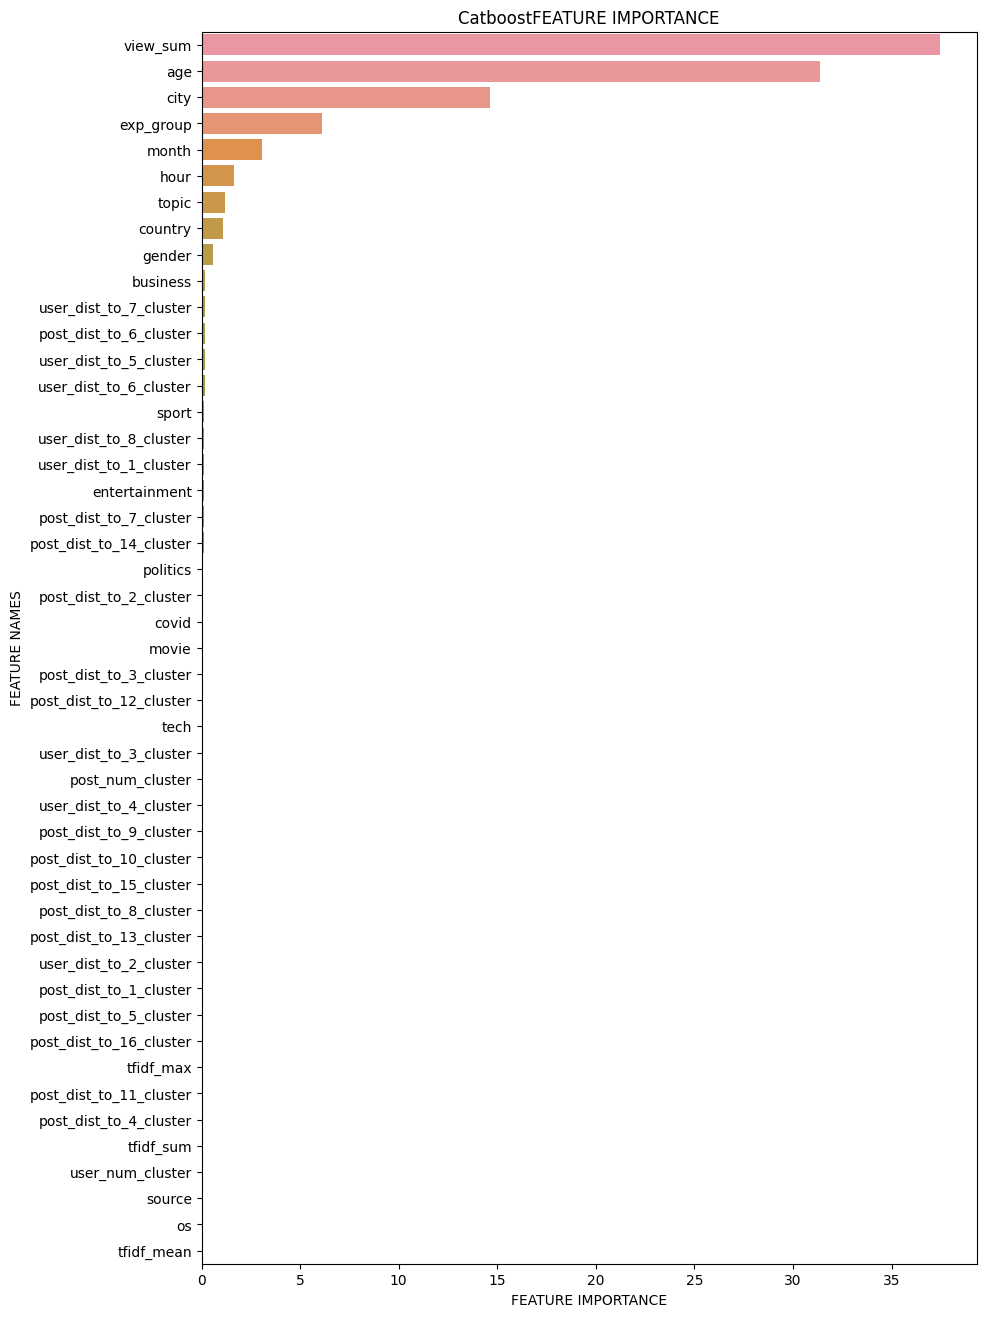

In [41]:
def plot_feature_importance(importance, names, model_type):

    # Создадим массивы из важности фичей и колонок
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Создадим датафрейм, используя словарь
    data = {'feature_names': feature_names,
            'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Отсортируем датафрейм в убывающем порядке по важности фичей
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10, 16))
    
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(catboost.feature_importances_,
                        X_train.columns, 'Catboost')

In [42]:
# Замерим качества на Кросс-Валидации на 5 фолдах

catboost_cv = cross_validate(catboost, X_train, y_train,
                         scoring="recall",
                         cv=splitter,
                         return_train_score=True)

0:	learn: 0.6653559	total: 121ms	remaining: 1m
1:	learn: 0.6092243	total: 227ms	remaining: 56.6s
2:	learn: 0.6537022	total: 356ms	remaining: 58.9s
3:	learn: 0.6341077	total: 457ms	remaining: 56.6s
4:	learn: 0.6737948	total: 565ms	remaining: 56s
5:	learn: 0.6720647	total: 659ms	remaining: 54.3s
6:	learn: 0.6726939	total: 745ms	remaining: 52.5s
7:	learn: 0.6727551	total: 841ms	remaining: 51.7s
8:	learn: 0.6731453	total: 939ms	remaining: 51.2s
9:	learn: 0.6749560	total: 1.04s	remaining: 51s
10:	learn: 0.6791438	total: 1.14s	remaining: 50.8s
11:	learn: 0.6800385	total: 1.24s	remaining: 50.5s
12:	learn: 0.6828994	total: 1.35s	remaining: 50.5s
13:	learn: 0.6833861	total: 1.45s	remaining: 50.2s
14:	learn: 0.6839755	total: 1.55s	remaining: 50s
15:	learn: 0.6824412	total: 1.64s	remaining: 49.6s
16:	learn: 0.6832154	total: 1.74s	remaining: 49.3s
17:	learn: 0.6831605	total: 1.83s	remaining: 49s
18:	learn: 0.6856426	total: 1.93s	remaining: 48.9s
19:	learn: 0.6857533	total: 2.04s	remaining: 49s
20:

In [43]:
print(
    f"Среднее recall на тренировочных фолдах: {np.mean(catboost_cv['train_score']).round(3)}"
)
print(
    f"Среднее recall на тестовых фолдах: {np.mean(catboost_cv['test_score']).round(3)}"
)

Среднее recall на тренировочных фолдах: 0.755
Среднее recall на тестовых фолдах: 0.757


## Сохранение и загрузка модели

In [44]:
# Сохраним модель

catboost.save_model(
    "model_control",
    format="cbm"                  
)

In [45]:
# Проверим что все сохранилось правильно

from_file = CatBoostClassifier()
from_file.load_model("model_control")
from_file.predict(X_test)

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

## Загрузка фичей на сервер

In [46]:
# Загрузим фичи юзеров 

user_data.to_sql(
    'maksim_maltsev_users_lesson_22',
    con=conn_url,
    schema='public',
    if_exists='replace',
    index=False
)

205

In [47]:
# Загрузим фичи постов 

post_text_df.to_sql(
    'maksim_maltsev_posts_lesson_22',
    con=conn_url,
    schema='public',
    if_exists='replace',
    index=False
)

23

In [48]:
# Функция для батчевой загрузки с сервера

def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(conn_url)
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

In [49]:
# Проверим загрузку фичей юзеров

users_load = batch_load_sql('maksim_maltsev_users_lesson_22')
users_load

,user_id,gender,age,country,city,exp_group,os,source,business,covid,...,tech,user_dist_to_1_cluster,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster
0,200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,...,13.0,3.017298,3.578527,2.979593,2.221977,3.635041,3.928811,3.857473,4.662269,3
1,201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,...,29.0,3.889771,6.056264,6.410042,4.467372,2.955178,3.267942,2.681371,3.399628,6
2,202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,...,21.0,3.697253,5.540520,5.193849,3.193716,4.013128,4.113622,1.987895,3.736802,6
3,203,0,18,Russia,Moscow,1,iOS,ads,19.0,71.0,...,9.0,2.231405,2.078781,2.905206,2.956871,4.808711,5.559321,4.258058,5.227635,1
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,8.0,31.0,...,3.0,4.150158,2.145474,2.923159,4.518076,5.788589,7.331909,6.518223,7.071422,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic,12.0,83.0,...,12.0,2.236369,2.476267,3.207184,2.973127,3.583664,4.963360,4.091713,4.888445,0
163201,168549,0,18,Russia,Tula,2,Android,organic,14.0,67.0,...,10.0,2.743732,1.837154,2.728837,3.329112,5.176081,6.015830,4.934188,5.767221,1
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic,29.0,85.0,...,14.0,3.264920,3.574120,2.974607,2.543692,3.043625,5.191638,4.237303,4.183708,3
163203,168551,0,38,Russia,Moscow,3,iOS,organic,21.0,122.0,...,15.0,2.247021,3.490732,4.051030,3.041200,2.884440,4.402915,3.253753,4.201481,0


In [50]:
# Проверим загрузку фичей постов

posts_load = batch_load_sql('maksim_maltsev_posts_lesson_22')
posts_load

,post_id,text,topic,tfidf_sum,tfidf_mean,tfidf_max,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,...,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster,view_sum
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.000190,0.495805,1.041581,1.017668,1.019208,1.000911,...,1.019183,1.006183,0.983297,1.004058,1.009302,0.919366,1.011768,1.030109,13,8508.0
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.000258,0.308003,1.037858,1.013259,1.015774,0.996825,...,1.014563,1.003411,0.967705,0.999901,1.007325,0.989098,1.011587,1.028142,10,7495.0
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.000276,0.261799,1.040713,1.011287,1.024541,0.997860,...,1.015846,1.005088,0.978229,1.006527,1.006882,0.950109,1.019272,1.027924,13,8412.0
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.000144,0.537713,1.041159,1.017468,1.029216,1.002180,...,1.020306,1.006496,0.977505,1.010382,1.009777,0.992911,1.022562,1.023690,10,8158.0
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.000138,0.420251,1.044158,1.021138,1.031516,1.003333,...,1.023036,1.008690,0.991778,1.020382,1.011292,1.025277,1.028433,1.033378,10,8583.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,6.703302,0.000146,0.258412,1.043225,0.960281,1.029320,0.978045,...,0.995749,1.007191,1.003917,1.024215,0.991503,1.036681,1.020494,1.035921,4,16940.0
7019,7316,I give this movie 2 stars purely because of it...,movie,6.471377,0.000141,0.399419,1.045262,0.977152,1.027771,0.986424,...,0.994587,1.008001,1.007605,1.023026,0.991832,1.035816,1.029342,1.037274,4,6572.0
7020,7317,I cant believe this film was allowed to be mad...,movie,5.628524,0.000122,0.573061,1.045768,0.995772,1.027710,0.991719,...,0.977319,1.008778,1.011118,1.031534,0.993021,1.042517,1.026203,1.036886,8,6803.0
7021,7318,The version I saw of this film was the Blockbu...,movie,6.883375,0.000150,0.231244,1.044712,0.982465,1.013551,0.981802,...,0.975618,1.008061,1.001428,1.023730,0.986877,1.032609,1.016756,1.034422,8,6785.0
